<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/sok_3022_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Starter med å importere to viktig libraries for LSTM

import tensorflow as tf
import pandas as pd

# Leser csv filen
df = pd.read_csv('/content/derivative.csv', delimiter=';')
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
df.head()

,date,Price,Adjusted Price,ExercisePrice,Settlement,EndofDayDelta,Volatility,VolatilityForValuation
0,2020-07-02,2.731,2.326168,5.0,0.25,29.9618,38.717,38.717
1,2020-07-03,2.710,2.308281,5.0,0.27,30.6566,38.032,38.032
2,2020-07-07,2.808,2.391754,5.0,0.27,30.5772,37.147,37.147
3,2020-07-08,2.743,2.336389,5.0,0.27,30.4483,37.230,37.230
4,2020-07-09,2.697,2.297208,5.0,0.23,28.4804,36.824,36.824


In [2]:
df.shape

(579, 8)

In [3]:
df.tail()

,date,Price,Adjusted Price,ExercisePrice,Settlement,EndofDayDelta,Volatility,VolatilityForValuation
574,2023-09-22,4.710,4.710,5.0,0.46,51.2059,27.0,27.210
575,2023-09-26,4.678,4.678,5.0,0.42,48.7327,27.0,27.675
576,2023-09-27,4.477,4.477,5.0,0.42,48.5023,27.0,27.629
577,2023-09-28,4.521,4.521,5.0,0.33,42.0959,27.0,27.611
578,2023-09-29,4.582,4.582,5.0,0.34,43.3272,27.0,27.412


In [4]:
import matplotlib.pyplot as plt
import datetime

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['Settlement'] = df['Settlement'].astype(float)

In [5]:
df = df.sort_values(by='date')

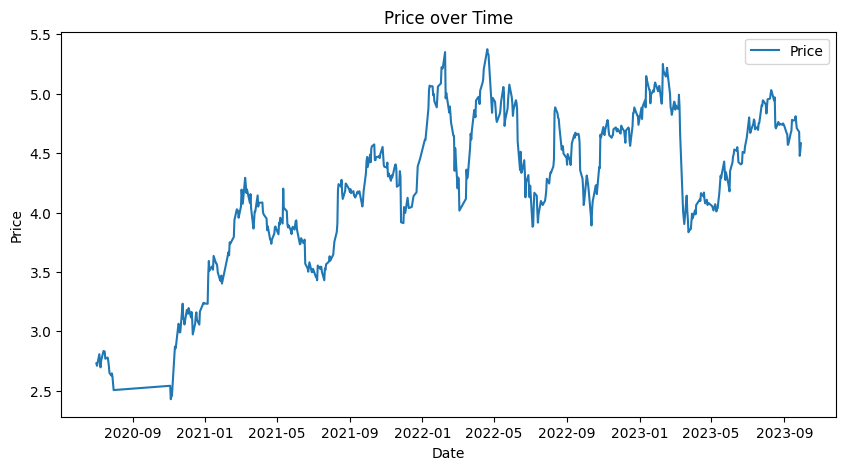

In [6]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['Price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price over Time')
plt.legend()
plt.show()

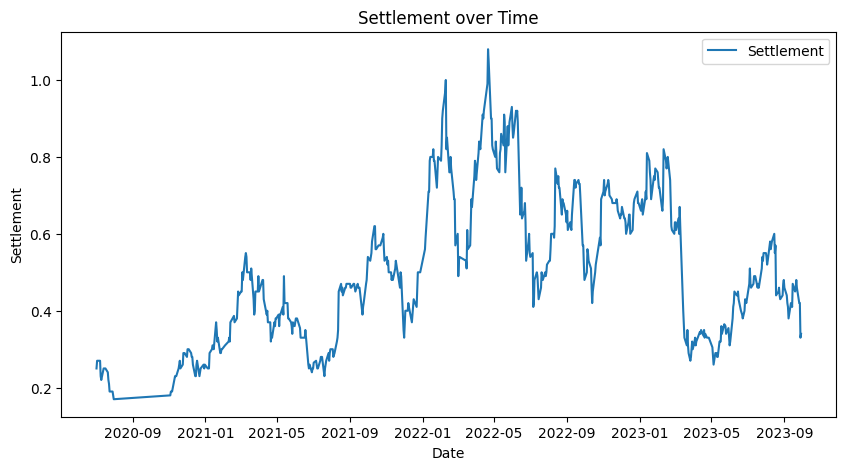

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['Settlement'], label='Settlement')
plt.xlabel('Date')
plt.ylabel('Settlement')
plt.title('Settlement over Time')
plt.legend()
plt.show()

In [8]:
### Funksjon som endrer et 'Object' med splitten '-' til datetime-variabel.
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2]) # Splitter på hver int (heltall)
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2023-03-19')
type(datetime_object)

datetime.datetime

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Konverter strengdatoer til datetime
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    # Sett 'Date' som indeks og sorter
    dataframe = dataframe.set_index('date').sort_index()

    target_date = first_date
    dates, X, Y = [], [], []

    last_time = False

    while not last_time:
        # Hent n+1 siste rader opp til target_date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        # Sjekk om det er nok data
        if len(df_subset) != n + 1:
            print(f"Feil: Vindu av størrelse {n} er for stort for {target_date}")
            return None

        # Hent verdiene (bruk 'Price' istedenfor 'Close')
        values = df_subset['Settlement'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Finn neste gyldige dato i indeksen
        try:
            current_idx = dataframe.index.get_loc(target_date)
            next_date = dataframe.index[current_idx + 1]
        except IndexError:
            break  # Ingen flere datoer

        target_date = next_date

        # Avslutt hvis vi når siste dato
        if target_date > last_date:
            last_time = True

    # Bygg resultatdataframe
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Eksempel på bruk
windowed_df = df_to_windowed_df(
    df,
    first_date_str='2020-07-08',
    last_date_str='2023-08-10',
    n=3
)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-07-08,0.25,0.27,0.27,0.27
1,2020-07-09,0.27,0.27,0.27,0.23
2,2020-07-10,0.27,0.27,0.23,0.22
3,2020-07-14,0.27,0.23,0.22,0.25
4,2020-07-16,0.23,0.22,0.25,0.25
...,...,...,...,...,...
542,2023-08-03,0.55,0.55,0.54,0.52
543,2023-08-04,0.55,0.54,0.52,0.53
544,2023-08-08,0.54,0.52,0.53,0.58
545,2023-08-09,0.52,0.53,0.58,0.56


In [10]:
# Her konverteres winowed_df om til våre features (X) og target (y). Kilde: Gregg Hogg (YouTube)

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((547,), (547, 3, 1), (547,))

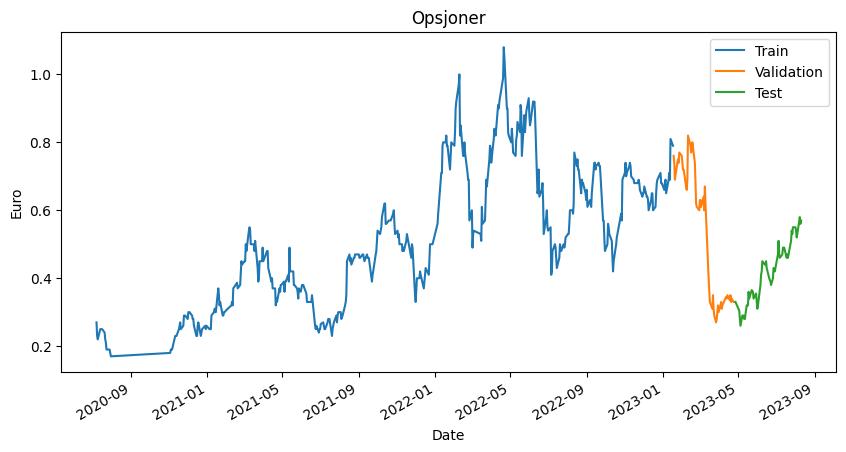

In [11]:
q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
plt.figure(figsize=(10, 5))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer fordi det ser pent ut:)

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('Euro')
plt.title('Opsjoner')

plt.legend(['Train', 'Validation', 'Test'])

# Vis plot
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[early_stopping])

#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2503 - mean_absolute_error: 0.4607 - val_loss: 0.1123 - val_mean_absolute_error: 0.2938
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0713 - mean_absolute_error: 0.2196 - val_loss: 0.0273 - val_mean_absolute_error: 0.1376
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - mean_absolute_error: 0.1338 - val_loss: 0.0133 - val_mean_absolute_error: 0.1068
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - mean_absolute_error: 0.0958 - val_loss: 0.0108 - val_mean_absolute_error: 0.0906
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - mean_absolute_error: 0.0820 - val_loss: 0.0091 - val_mean_absolute_error: 0.0808
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - mean_absolute_error: 0.0737 - val_loss: 0.0074 - val_mean_absolute_error: 0.0712
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0620 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


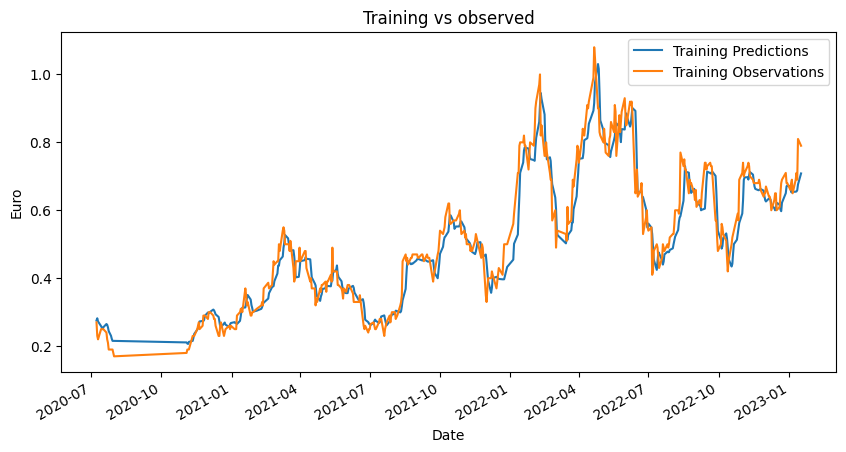

In [13]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(10, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# Formaterer x-aksen
plt.gcf().autofmt_xdate() # auto roter

# labels og title
plt.xlabel('Date')
plt.ylabel('Euro')
plt.title('Training vs observed')

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


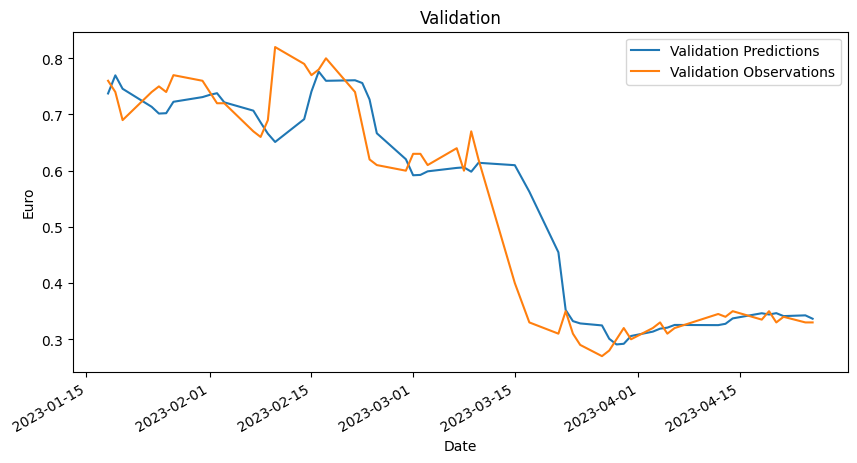

In [14]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(10, 5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer fordi det ser pent ut:)


# Adder labels og title
plt.xlabel('Date')
plt.ylabel('Euro')
plt.title('Validation')

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


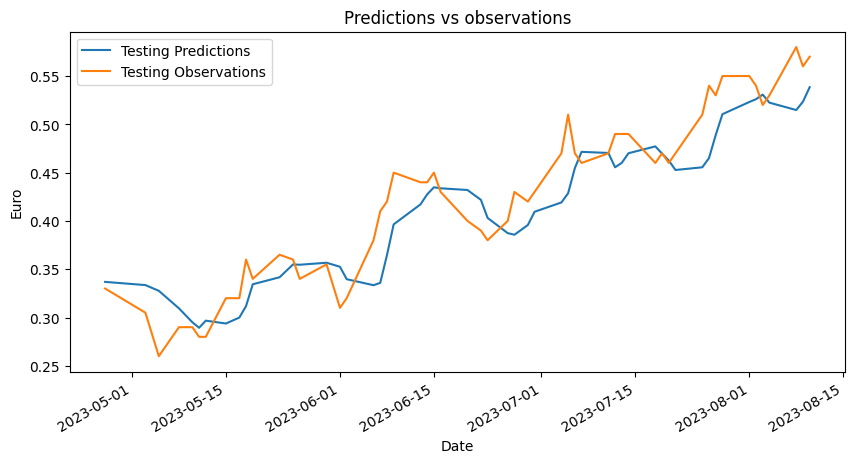

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(10, 5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer fordi det ser pent ut:)

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('Euro')
plt.title('Predictions vs observations')

# Vis plot
plt.show()

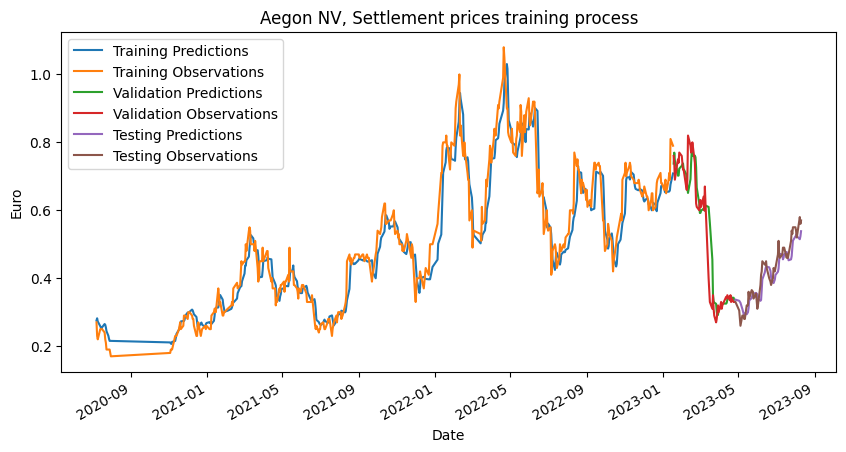

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('Euro')
plt.title('Aegon NV, Settlement prices training process')

plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, test_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, test_predictions)

# Outputs
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0276
Mean Squared Error (MSE): 0.0012
Root Mean Squared Error (RMSE): 0.0344
R-squared (R²): 0.8408


In [18]:
# Create a DataFrame for the table
results_df = pd.DataFrame({
    'Date': dates_test,
    'Observed': y_test,
    'Predicted': test_predictions
})

# Display the table
results_df


,Date,Observed,Predicted
0,2023-04-27,0.330,0.336879
1,2023-05-03,0.305,0.333569
2,2023-05-05,0.260,0.327626
3,2023-05-08,0.290,0.309506
4,2023-05-10,0.290,0.295087
5,2023-05-11,0.280,0.289379
6,2023-05-12,0.280,0.296730
7,2023-05-15,0.320,0.293780
8,2023-05-17,0.320,0.299933
9,2023-05-18,0.360,0.311789
